# Cell Division 

## On a 2D mesh

In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
import ipyvolume as ipv
%matplotlib inline

from tyssue import Sheet, config


from tyssue.geometry.planar_geometry import PlanarGeometry as geom
from tyssue.solvers.quasistatic import QSSolver
from tyssue.dynamics.planar_vertex_model import PlanarModel as model

from tyssue.draw import sheet_view
from tyssue.stores import load_datasets

from tyssue.topology.sheet_topology import remove_face, cell_division


Reseting column is_alive of the face dataset with new specs
Reseting column ux of the edge dataset with new specs
Reseting column uy of the edge dataset with new specs
Reseting column is_active of the vert dataset with new specs


Number of cells: 20
          edges: 100
          vertices: 38



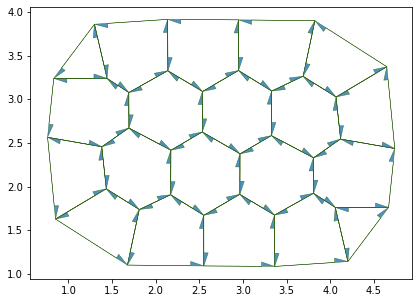

In [2]:
solver = QSSolver()
sheet = Sheet.planar_sheet_2d('division', 6, 6, 1, 1)
sheet.sanitize(trim_borders=True, order_edges=True)
geom.update_all(sheet)

sheet.get_opposite()

# ## Set up the model
nondim_specs = config.dynamics.quasistatic_plane_spec()
dim_model_specs = model.dimensionalize(nondim_specs)
sheet.update_specs(dim_model_specs, reset=True)

print("Number of cells: {}\n"
      "          edges: {}\n"
      "          vertices: {}\n".format(sheet.Nf, sheet.Ne, sheet.Nv))

# ## Minimize energy
res = solver.find_energy_min(sheet, geom, model)

# ## View the result
draw_specs = config.draw.sheet_spec()
draw_specs['vert']['visible'] = False
draw_specs['edge']['head_width'] = 0.1
fig, ax = sheet_view(sheet, **draw_specs)
fig.set_size_inches(12, 5)

True


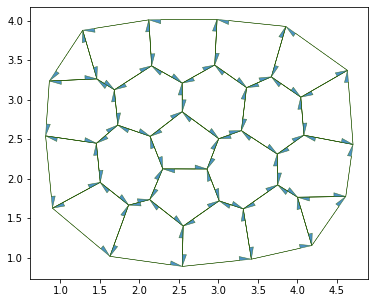

In [3]:
daughter = cell_division(sheet, 7, geom, angle=np.pi/2)

res = solver.find_energy_min(sheet, geom, model)
print(res['success'])

fig, ax = sheet_view(sheet, **draw_specs)
fig.set_size_inches(12, 5)

## Division in a 3D single layer epithelium

In [4]:
from tyssue.io.hdf5 import save_datasets, load_datasets
# redefine cell_division from monolayer related topology module
from tyssue.topology.monolayer_topology import cell_division

from tyssue.core.monolayer import Monolayer
from tyssue.geometry.bulk_geometry import ClosedMonolayerGeometry as monolayer_geom
from tyssue.dynamics.bulk_model import ClosedMonolayerModel
from tyssue.draw import highlight_cells



In [5]:
datasets = load_datasets('data/small_ellipsoid.hf5',
                         data_names=['vert', 'edge',
                                     'face', 'cell'])

specs = config.geometry.bulk_spec()
monolayer = Monolayer('ell', datasets, specs)
monolayer_geom.update_all(monolayer)

specs = {
    "edge": {
        "line_tension": 0.0,
    },
    "face": {
        "contractility": 0.01,
    },
    "cell": {
        "prefered_vol": monolayer.cell_df['vol'].median(),
        "vol_elasticity": 0.1,
        "prefered_area": monolayer.cell_df['area'].median(),
        "area_elasticity": 0.1,
    },
    "settings": {
        'lumen_prefered_vol': monolayer.settings['lumen_vol'],
        'lumen_vol_elasticity': 1e-2

    }
}

monolayer.update_specs(specs, reset=True)

res = solver.find_energy_min(monolayer, monolayer_geom, ClosedMonolayerModel)


Reseting column line_tension of the edge dataset with new specs
Reseting column contractility of the face dataset with new specs
Reseting column prefered_vol of the cell dataset with new specs
Reseting column vol_elasticity of the cell dataset with new specs


In [6]:
mother = 8
daughter = cell_division(monolayer, mother, 
                         orientation='vertical')

monolayer.validate()

True

In [7]:
rho = np.linalg.norm(monolayer.vert_df[monolayer.coords], axis=1)
draw_specs['edge']['color'] = rho
draw_specs['face']['visible'] = True

ipv.clear()
highlight_cells(monolayer, mother, reset_visible=True)
fig, mesh = sheet_view(monolayer, mode="3D",
                    coords=['z', 'x', 'y'], **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [8]:
mother = 18
daughter = cell_division(monolayer, mother, 
                         orientation='horizontal')
monolayer.validate()

True

In [9]:
rho = np.linalg.norm(monolayer.vert_df[monolayer.coords], axis=1)
draw_specs['edge']['color'] = rho
draw_specs['face']['visible'] = True
ipv.clear()
highlight_cells(monolayer, mother)
fig, mesh = sheet_view(monolayer, mode="3D",
                    coords=['z', 'x', 'y'], **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

#### Energy minimisation of the monolayer after division


In [10]:

monolayer.cell_df.loc[[mother, daughter], 'prefered_area'] /= 2
monolayer.cell_df.loc[[mother, daughter], 'prefered_vol'] /= 3
monolayer.settings['lumen_prefered_vol'] = monolayer.settings['lumen_vol']
monolayer.settings['lumen_vol_elasticity'] = 1e-2

res = solver.find_energy_min(monolayer, monolayer_geom, ClosedMonolayerModel)
print(res['message'])


b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'


In [11]:
rho = np.linalg.norm(monolayer.vert_df[monolayer.coords], axis=1)
draw_specs['edge']['color'] = rho
ipv.clear()
highlight_cells(monolayer, mother)
fig, mesh = sheet_view(monolayer, mode="3D",
                    coords=['z', 'x', 'y'], **draw_specs)
fig

Figure(camera=PerspectiveCamera(fov=45.0, position=(0.0, 0.0, 2.0), quaternion=(0.0, 0.0, 0.0, 1.0), scale=(1.…

In [15]:
from tyssue.generation import three_faces_sheet, extrude
from tyssue.geometry.bulk_geometry import MonoLayerGeometry


datasets_2d, _ = three_faces_sheet(zaxis=True)
datasets = extrude(datasets_2d, method='translation')
eptm = Monolayer('test_volume', datasets, 
                 config.geometry.bulk_spec(),
                 coords=['x','y','z'])
#eptm.vert_df[eptm.coords] += np.random.normal(scale=1e-6,
#                                              size=eptm.vert_df[eptm.coords].shape)
MonoLayerGeometry.update_all(eptm)

for orientation in ['vertical', 'horizontal']:
    print(orientation)
    daughter = cell_division(eptm, 1, orientation=orientation)
    eptm.reset_topo()
    eptm.reset_index()
    MonoLayerGeometry.update_all(eptm)
    print(f'Valid division for {orientation}:')
    print(eptm.validate()) #break

vertical
Valid division for vertical:
True
horizontal


KeyError: 34

In [1]:
import os
import tempfile
import numpy as np
import pandas as pd

from tyssue.core.sheet import Sheet
from tyssue.stores import stores_dir
from tyssue.io.hdf5 import load_datasets
from tyssue.generation import three_faces_sheet
from tyssue import config
from tyssue.geometry.sheet_geometry import SheetGeometry as geom

from tyssue.behaviors.event_manager import EventManager, wait
from tyssue.behaviors.sheet.basic_events import (
    division,
    contraction,
    type1_transition,
    face_elimination,
    check_tri_faces,
)
from tyssue.behaviors.sheet.actions import (
    ab_pull,
    relax,
    set_value,
    increase,
    decrease,
    increase_linear_tension,
    grow,
)
from tyssue.behaviors.sheet.actions import remove as type3
from tyssue.behaviors.sheet.actions import exchange as type1_at_shorter
from tyssue.behaviors.sheet.apoptosis_events import apoptosis
from tyssue.behaviors.sheet.delamination_events import constriction



In [25]:
%pdb

Automatic pdb calling has been turned ON


In [2]:
h5store = os.path.join(stores_dir, "small_hexagonal.hf5")
datasets = load_datasets(h5store, data_names=["face", "vert", "edge"])
specs = config.geometry.cylindrical_sheet()
sheet = Sheet("emin", datasets, specs)
geom.update_all(sheet)
sheet.settings["apoptosis"] = {"contractile_increase": 2.0, "critical_area": 0.1}
sheet.face_df["id"] = sheet.face_df.index.values
init_nb_faces = len(sheet.face_df)
manager = EventManager("face")
face_id = 17
face_area = sheet.face_df.loc[face_id, "area"]
initial_nbsides = sheet.face_df.loc[face_id, "num_sides"]

sheet.settings["apoptosis"].update({"face_id": face_id})
initial_cell_event = (apoptosis, sheet.settings["apoptosis"])

manager.current.append(initial_cell_event)
manager.execute(sheet)
manager.update()
assert len(manager.current) > 0
manager.execute(sheet)
manager.update()

sheet.settings["apoptosis"] = {
    "contractile_increase": 2.0,
    "critical_area": 2 * face_area,
}
manager.current.clear()
sheet.settings["apoptosis"].update({"face_id": face_id})
modified_cell_event = (apoptosis, sheet.settings["apoptosis"])

manager.current.append(modified_cell_event)
sheet.reset_index()

manager.execute(sheet)
manager.update()

# next_nbsides = sheet.face_df.loc[sheet.idx_lookup(face_id, "face"), "num_sides"]
# i = 1
# while next_nbsides > 4:
#     assert next_nbsides == initial_nbsides - i
#     assert len(manager.current) > 0
#     i = i + 1
#     manager.execute(sheet)
#     manager.update()
#     next_nbsides = sheet.face_df.loc[sheet.idx_lookup(face_id, "face"), "num_sides"]
#     if i > 20:
#         raise RecursionError
# manager.execute(sheet)
# manager.update()
# assert len(sheet.face_df) < init_nb_faces


dropped two sided cells


/home/guillaume/miniconda3/envs/tyssue/lib/python3.7/site-packages/tyssue-0.7.1-py3.7-linux-x86_64.egg/tyssue/topology/sheet_topology.py:29: UserWarning: The epsilon argument is deprecated and will be removed in a future version. The length of the new edge should be set by `sheet.settings['threshold_length]*multiplier` 
  "The epsilon argument is deprecated and will be removed in a future version. "


In [49]:
sheet.edge_df.loc[82 ,['srce', 'trgt', 'face']]

srce    27.0
trgt    28.0
face    17.0
Name: 82, dtype: float64

In [50]:
from tyssue.topology.sheet_topology import collapse_edge

In [42]:
from tyssue.topology.sheet_topology import type1_transition as t1_trans

In [44]:
t1_trans(sheet, 82)

ValueError: not enough values to unpack (expected 1, got 0)

> /home/guillaume/miniconda3/envs/tyssue/lib/python3.7/site-packages/tyssue-0.7.1-py3.7-linux-x86_64.egg/tyssue/topology/sheet_topology.py(37)split_vert()
     35 
     36     face_edges = sheet.edge_df.query(f"face == {face}")
---> 37     (prev_v,) = face_edges[face_edges["trgt"] == vert]["srce"]
     38     (next_v,) = face_edges[face_edges["srce"] == vert]["trgt"]
     39     connected = sheet.edge_df[

ipdb> c


In [39]:
manager.current


deque([(<function tyssue.behaviors.sheet.apoptosis_events.apoptosis(sheet, manager, **kwargs)>,
        {'contractile_increase': 2.0,
         'critical_area': 37.73023647978214,
         'face_id': 17})])

In [31]:
initial_cell_event

(<function tyssue.behaviors.sheet.apoptosis_events.apoptosis(sheet, manager, **kwargs)>,
 {'contractile_increase': 2.0, 'critical_area': 0.1, 'face_id': 17})

In [32]:
modified_cell_event

(<function tyssue.behaviors.sheet.apoptosis_events.apoptosis(sheet, manager, **kwargs)>,
 {'contractile_increase': 2.0,
  'critical_area': 37.73023647978214,
  'face_id': 17})

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f7c948a3650>)

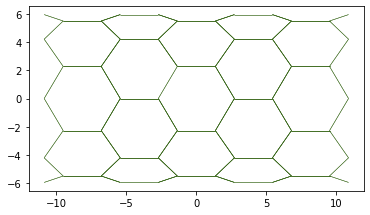

In [34]:
sheet_view(sheet, coords=['z', "x"])